# Compares the ASC speed produced by Wilma's code, and compares with monthly calculations averaged yearly

Just a simple comparisson

We want to discount the Zonal convergence. But this var is binned differently. Check stewart et al 2017 for calculations of ZC, and how to discoiunt it

Load modules:

In [1]:
%matplotlib inline
# Standard modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import os
from dask.distributed import Client
# Optional modules
import xgcm
# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client() # n_workers=4
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37185,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:33355,Total threads: 4
Dashboard: /proxy/46641/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:40643,


In [3]:
import cosima_cookbook as cc
session = cc.database.create_session()

## Basic Check

Test to check if the ASC speed calculated monthly and averaged afterwards gets the field as fould by Wilma

In [4]:
#importing [Monthly] ASC speed from year 2095 to 2098
import glob
src = '/g/data/x77/wf4500/ASC_project/ASC_speed/monthly/OM2_RYF/Antarctic_slope_contour_1km_velocities_209'
gl =glob.glob(src + "****_uv.nc")
gl=sorted(gl)
print("%i netcdf data files"%len(gl))
##importing data from ocean.nc
Along_slope_v=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
Along_slope_v_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

48 netcdf data files


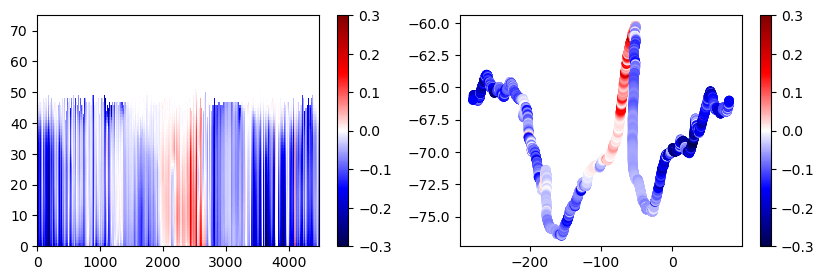

In [5]:
fig = plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.pcolormesh(Along_slope_v.u_along_contour,vmin=-0.3, vmax=0.3,cmap='seismic')
plt.colorbar()


plt.subplot(1,2,2)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.colorbar()
#seems to be the same as the plot in calc_u_on_depth_contour.ipynb 

It seems correct on a annual mean. Lets see accross the months

In [6]:
%%time
#First fixing the time dimension
experiment = '01deg_jra55v13_ryf9091'
variable = 'time'
start_time='2095-01-01'
end_time='2098-12-31'

timedim = cc.querying.getvar(experiment, 'time', session, start_time=start_time, end_time=end_time, frequency='1 monthly')
timedim = timedim.isel(time=slice(4,100,2)) #Only 2080 and 2081
Along_slope_v_time['time']=timedim.time

CPU times: user 33.3 s, sys: 12.4 s, total: 45.7 s
Wall time: 1min 44s


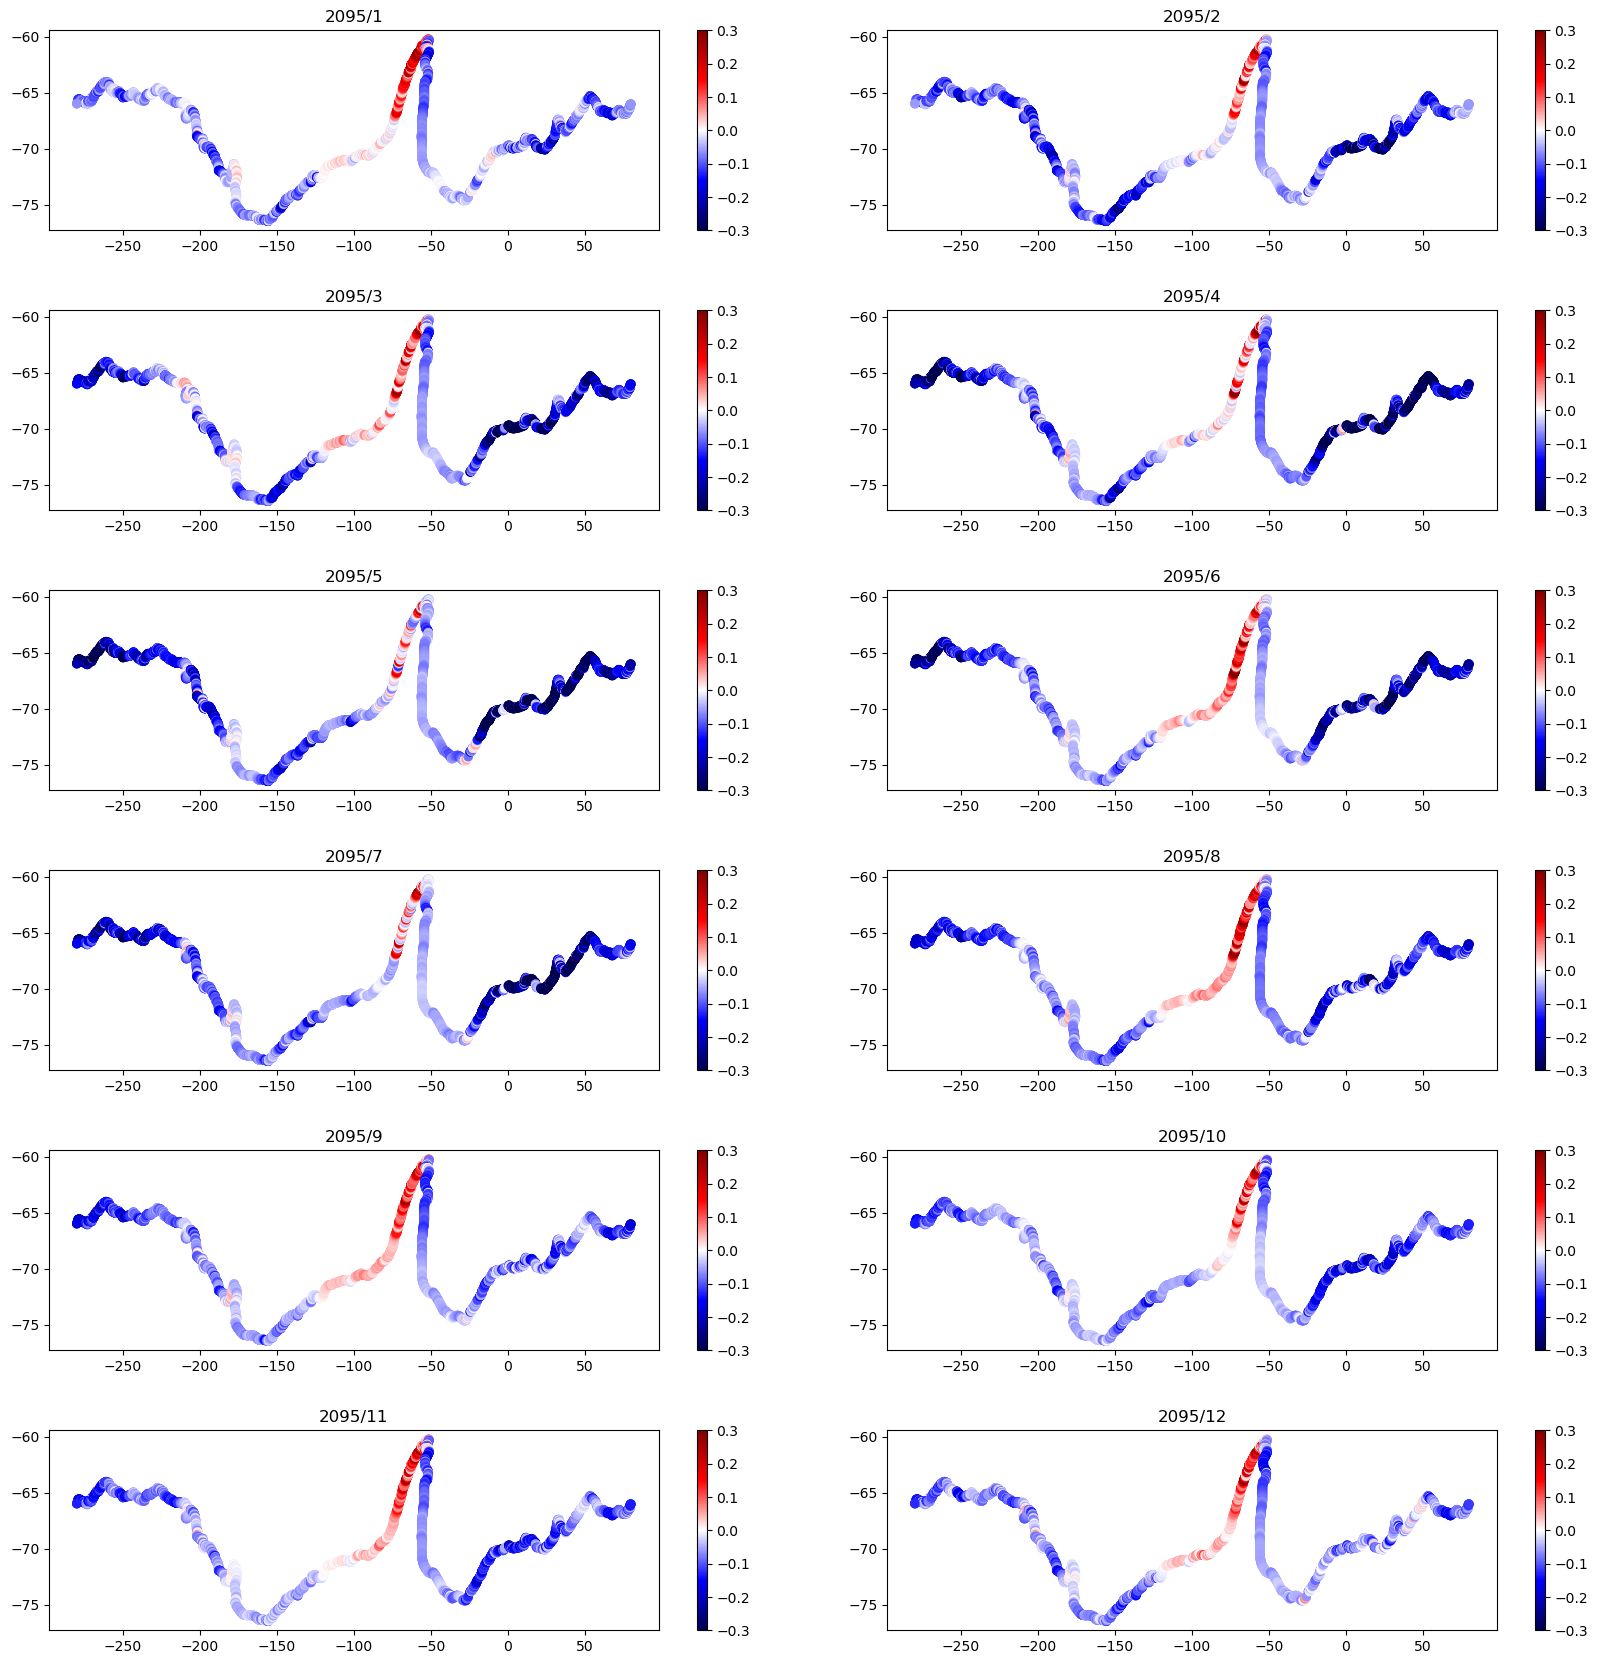

In [7]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)





for imonth in np.arange(0,12):
    plt.subplot(6,2,imonth+1)
    plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
                c=Along_slope_v_time.u_along_contour.isel(st_ocean=0,time=imonth),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
    plt.title('2095/' + str(imonth+1))
    plt.colorbar()

Interesting, on the Weddell and Ross Sea ASC **at surface** seem to be stronger in the Autumn and Winter

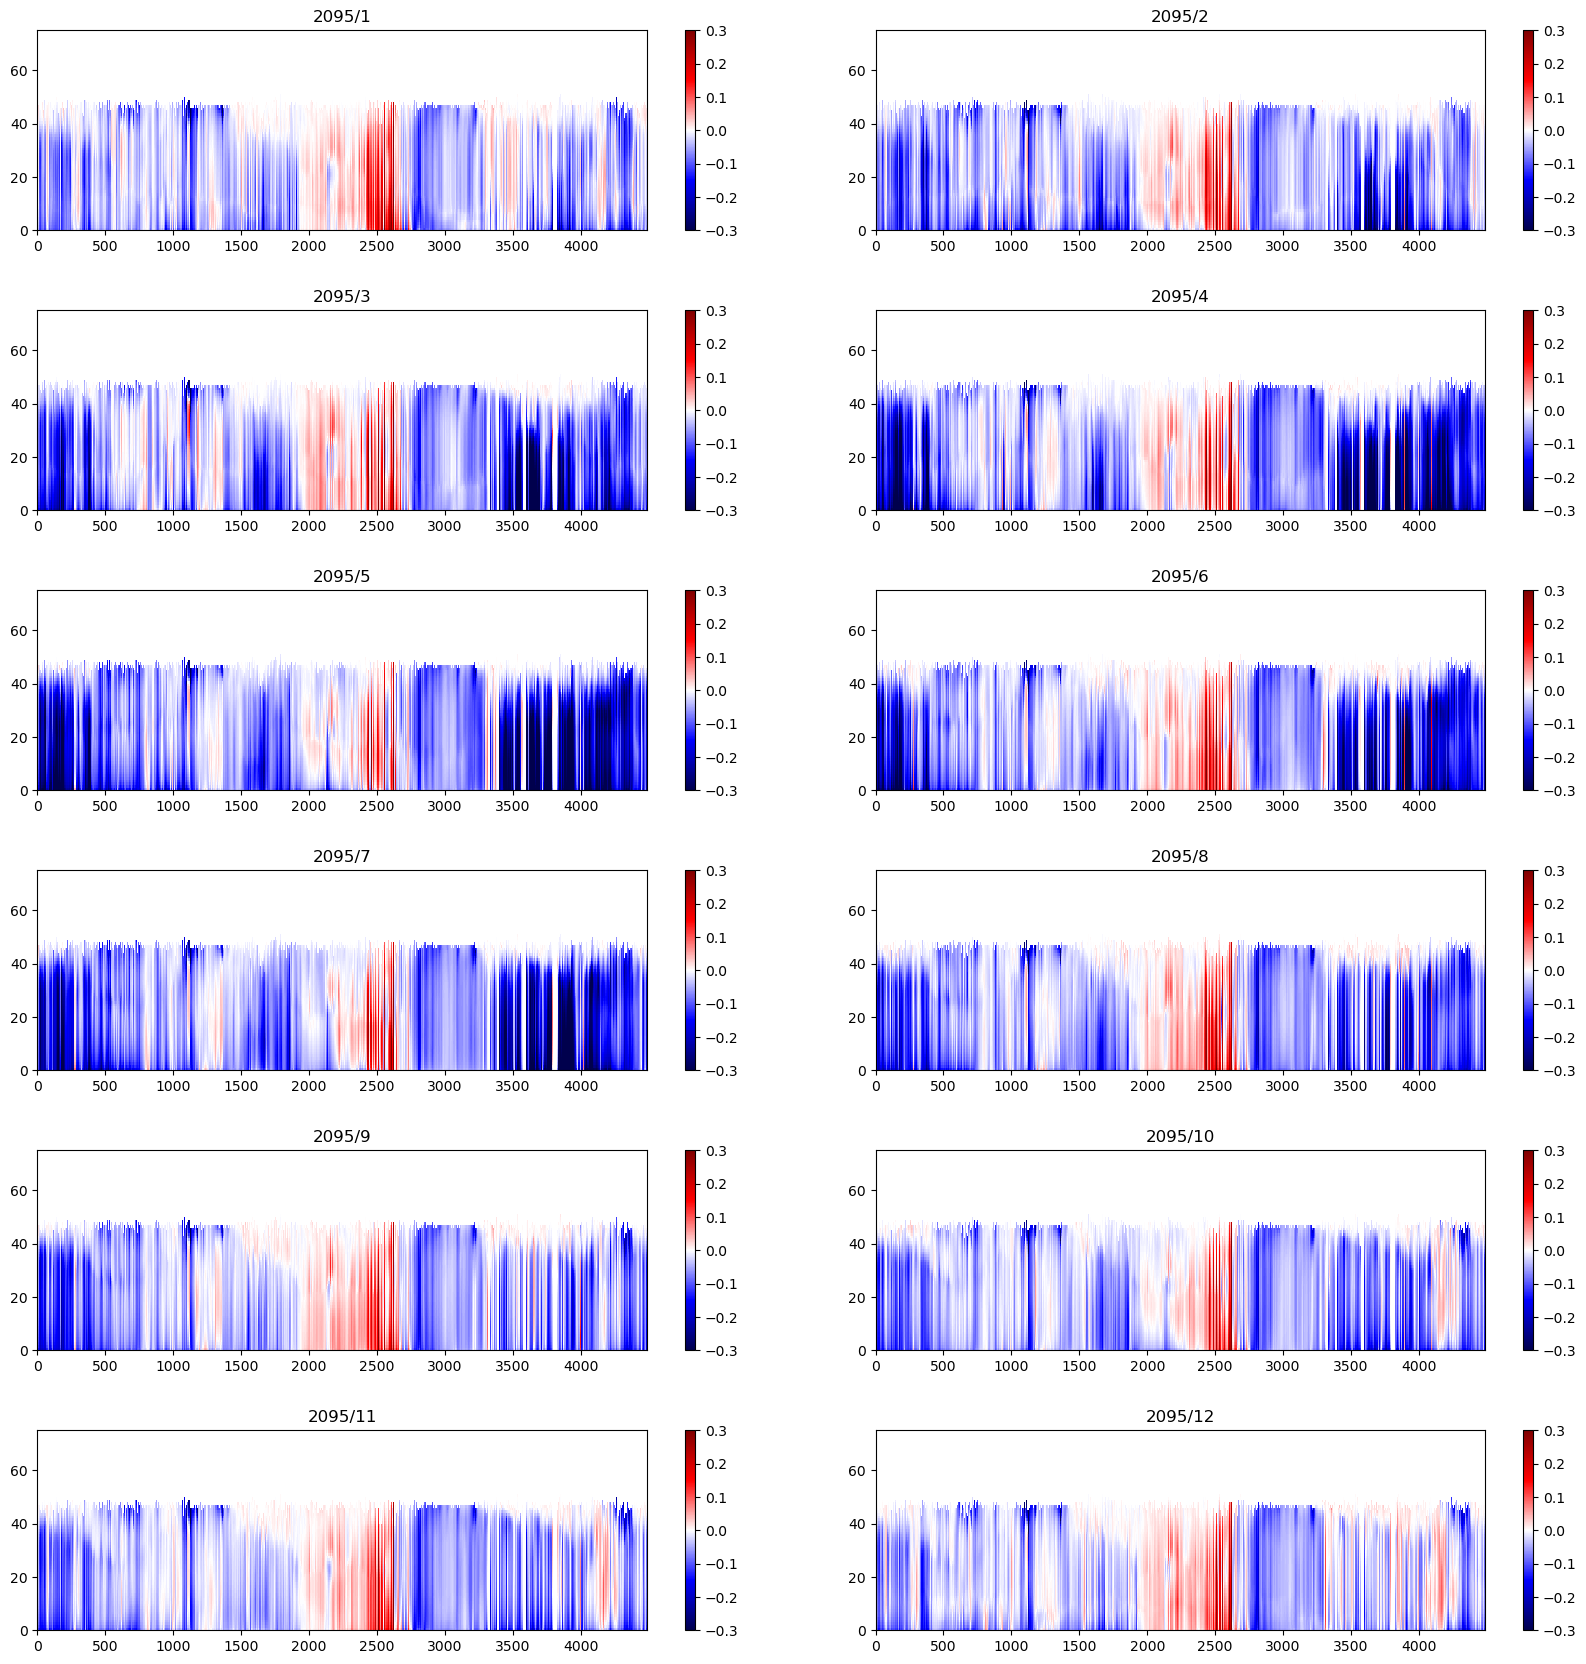

In [8]:
fig = plt.figure(figsize=(20,20))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.4)


for imonth in np.arange(0,12):
    plt.subplot(6,2,imonth+1)
    plt.pcolormesh(Along_slope_v_time.u_along_contour.isel(time=imonth),vmin=-0.3, vmax=0.3,cmap='seismic')
    plt.title('2095/' + str(imonth+1))
    plt.colorbar()

Now lets plot mean ASC and Standard Deviation, just so see what it shows.

In [9]:
#calculating STDs for the whole 2 years
Along_slope_v_time_std = Along_slope_v_time.u_along_contour.std(dim='time')

Plotting now

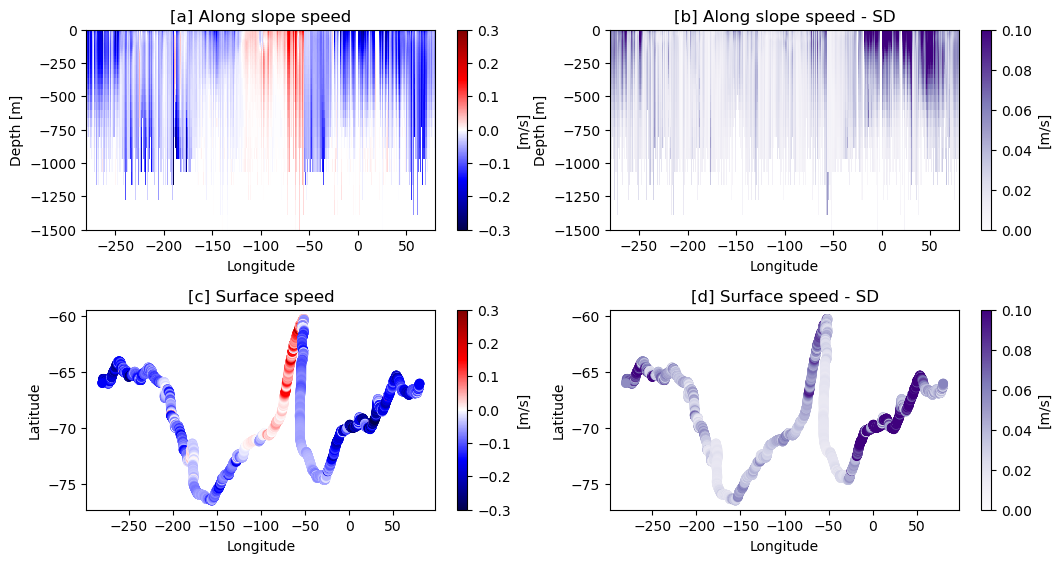

In [12]:
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)



plt.subplot(2,2,1)
plt.pcolormesh(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(0,4486)),-Along_slope_v.st_ocean,
         Along_slope_v.u_along_contour.isel(distance_along_contour=slice(0,4486)),vmin=-0.3, vmax=0.3,cmap='seismic')

plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.colorbar(label='[m/s]')
plt.title('[a] Along slope speed')

plt.subplot(2,2,2)

plt.pcolormesh(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(0,4486)),-Along_slope_v.st_ocean,
         Along_slope_v_time_std.isel(distance_along_contour=slice(0,4486)),vmin=0, vmax=0.1,cmap='Purples')
plt.ylim(-1500,0)
plt.xlabel('Longitude')
plt.ylabel('Depth [m]')
plt.title('[b] Along slope speed - SD')
plt.colorbar(label='[m/s]')

plt.subplot(2,2,3)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[c] Surface speed')
plt.colorbar(label='[m/s]')

plt.subplot(2,2,4)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v_time_std.isel(st_ocean=0),vmin=0, vmax=0.1, s=35, cmap='Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[d] Surface speed - SD')
plt.colorbar(label='[m/s]')

Further analysis to make:
    1-Spatial mean of ASC U(s,t)( Should I delete the Antarctic Peninsula?). Get temporal variability along Antarctica
    2-Import cross slope heat transport for the same period. How is the mean? How is the Variability along space(STD) and time (same as 1 for heat transport)

## Mean ASC speed 

I will calculate the spatial average of the ASC speed in two cases, C1 using all the velocities, and C2 will be removing the West Antarctic Peninsula.

Frist lets separate the indexes of the Antarctic peninsulat to be remove from the account. The area between minrange and macrange will be out of the count in C2

Text(0.5, 1.0, 'minlon= -100.00000000000345 and maxlon = -51.1000000000053')

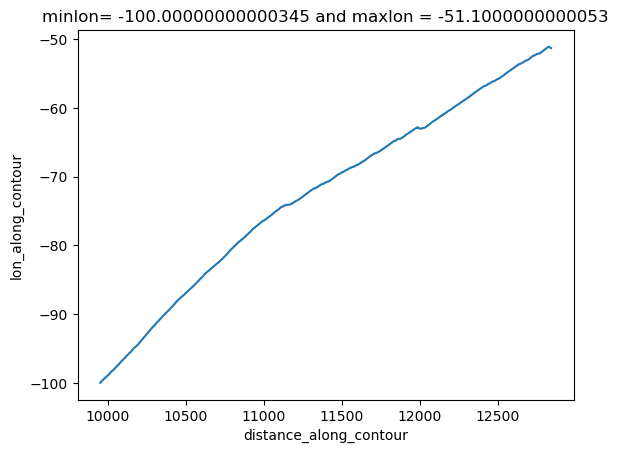

In [13]:
minrange=2144
maxrange=minrange+540
minlon=np.nanmin(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))
maxlon=np.nanmax(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))
Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)).plot()
plt.title("minlon= " + str(minlon) +
         " and maxlon = " + str(maxlon))

In [14]:
np.nanmin(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1))),np.nanmax(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))

(-100.00000000000345, -51.1000000000053)

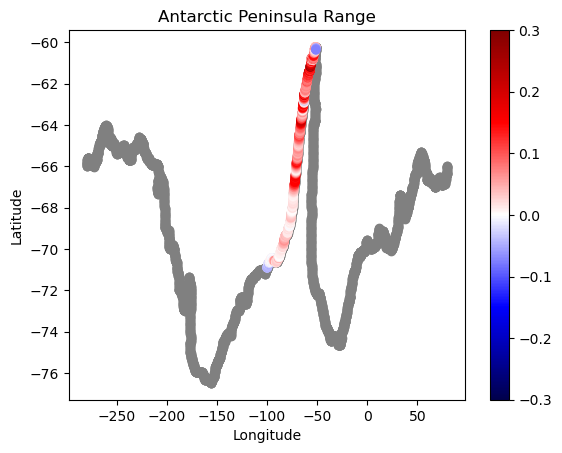

In [15]:
minrange=2144
maxrange=minrange+540
plt.scatter(Along_slope_v.lon_along_contour,
            Along_slope_v.lat_along_contour, 
            color='grey')
plt.scatter(Along_slope_v.lon_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)),
            Along_slope_v.lat_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)), 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0).isel(distance_along_contour=slice(minrange,maxrange,1))
            ,vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Antarctic Peninsula Range')
plt.colorbar()

In [16]:
#Importing dzt and tarea for averaging
dzt = cc.querying.getvar(experiment, 'dzt', session, n=1).isel(time=0)
dzt_along_contour = dzt.sel(xt_ocean=Along_slope_v.lon_along_contour,yt_ocean=Along_slope_v.lat_along_contour,method='nearest')

tarea = cc.querying.getvar(experiment, 'tarea', session, n=1)
tarea = tarea.rename(nx='xt_ocean',ny='yt_ocean')
tarea['xt_ocean']=dzt.xt_ocean
tarea['yt_ocean']=dzt.yt_ocean
tarea_along_contour = tarea.sel(xt_ocean=Along_slope_v.lon_along_contour,yt_ocean=Along_slope_v.lat_along_contour,method='nearest')

Checking the area to see if it is correct

(-80.0, -50.0)

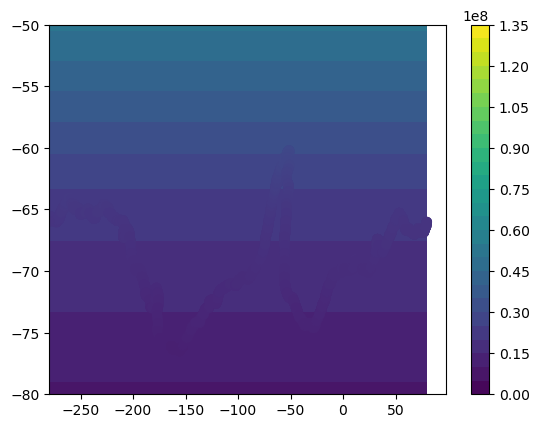

In [17]:
plorange=np.arange(0,1.4e8,5e6)
plt.contourf(dzt.xt_ocean,dzt.yt_ocean,tarea,plorange)
plt.colorbar()
plt.scatter(Along_slope_v.lon_along_contour,
            Along_slope_v.lat_along_contour,c=np.array(tarea_along_contour),
            vmin=-0, vmax=1.4e8, s=40)
plt.ylim(-80,-50)


Since Areas Along the line contour are similar to the grid plot of areas, then the extraction is probably right

Calculating the total mean ASC flux (C1)

In [18]:
%%time
# First calculating the volume to use as a weight
vol_along_contour=tarea_along_contour*dzt_along_contour

#first month is 
ASC_u = np.nansum(Along_slope_v_time.u_along_contour.isel(time=0)*vol_along_contour)/np.nansum(vol_along_contour)

for n in np.arange(1,48):
    ASC_u0=Along_slope_v_time.u_along_contour.isel(time=n)
    ASC_u1=np.nansum(ASC_u0*vol_along_contour)/np.nansum(vol_along_contour)
    ASC_u = np.append(ASC_u,ASC_u1)

CPU times: user 1min 2s, sys: 2.98 s, total: 1min 5s
Wall time: 1min 23s


Now calculating the same only in the AP, so we can remove it from the C1 to obtain C2

In [19]:
%%time
#first month is 
ASC_uAP = np.nansum(Along_slope_v_time.u_along_contour.isel(time=0).isel(distance_along_contour=slice(minrange,maxrange,1))*vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))/np.nansum(vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))

for n in np.arange(1,48):
    ASC_u0=Along_slope_v_time.u_along_contour.isel(time=n).isel(distance_along_contour=slice(minrange,maxrange,1))
    ASC_u1=np.nansum(ASC_u0*vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))/np.nansum(vol_along_contour.isel(distance_along_contour=slice(minrange,maxrange,1)))
    ASC_uAP = np.append(ASC_uAP,ASC_u1)

CPU times: user 1min 4s, sys: 2.8 s, total: 1min 7s
Wall time: 1min 23s


ASC speed without the AP speed  (C2) will be ASC_u -  ASC_uAP:

In [20]:
ASC_unoAP=ASC_u-ASC_uAP

Text(0.5, 1.0, '01deg_jra55v13_ryf9091: yr 2095 to 2098')

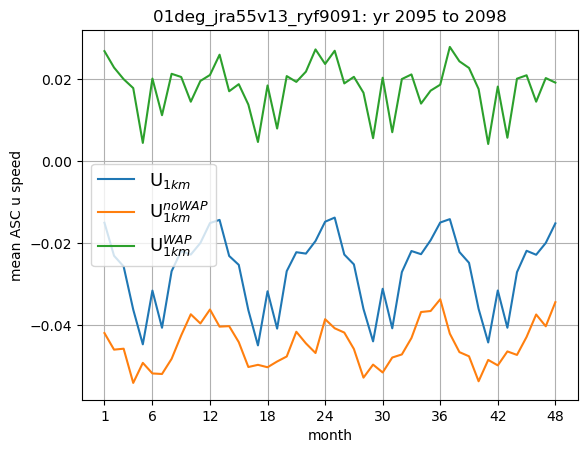

In [21]:
plt.plot(np.arange(1,49),ASC_u,label=r'U$_{1km}$')
plt.plot(np.arange(1,49),ASC_unoAP,label=r'U$_{1km}^{noWAP}$')
plt.plot(np.arange(1,49),ASC_uAP,label=r'U$_{1km}^{WAP}$')
plt.xlabel('month')
plt.ylabel('mean ASC u speed')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])
plt.legend(fontsize=13)
plt.title(experiment + ': yr 2095 to 2098')

Interesting that it changes the month og the peak when we include or not the AP.

Lets now compare what we find here with the Cross-slope heat transport

## Cross slope heat transport

First, lets import the heat transports

In [22]:
#importing Cross 1000m isobath heat transport
src = '/g/data/x77/wf4500/ASC_project/cross_slope_transport/Monthly/01deg_jra55v13_ryf9091/Ant_cross_slope_heat_terms_online_1000m_209'
gl =glob.glob(src + "****.nc")
gl=sorted(gl)
Heat_transp=xr.open_mfdataset(gl, concat_dim='time', combine='nested').mean('time')
Heat_transp_time=xr.open_mfdataset(gl, concat_dim='time', combine='nested')

In [23]:
#Substituting the time dimension
Heat_transp_time['time']=timedim.time

Lets Calculate the STD for the heat transport. Does it resemble the ASC speed std? (Is variability in speed and cross shelf ehat transport similar?)

In [58]:
Heat_transp_time_std=Heat_transp_time.cross_slope_heat_trans.std(dim='time')
Heat_transp_time_CONTOUR_std=Heat_transp_time.heat_trans_across_contour.std(dim='time')
Cross_slope_heat_trans_std = (Heat_transp_time.cross_slope_heat_trans*factor - Heat_transp_time.zonal_convergence*factor).std(dim='time')

The lat_along_contour, wasnt saved in the entcdf. SI just will collate it here so we can have the appropriate indexing)

In [25]:
lat_along_contour=xr.open_dataset('/g/data/x77/wf4500/ASC_project/cross_slope_transport/lat_along_contour.nc')
lat_along_contour= lat_along_contour.__xarray_dataarray_variable__

In [34]:
factor=0.08130129165602648

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


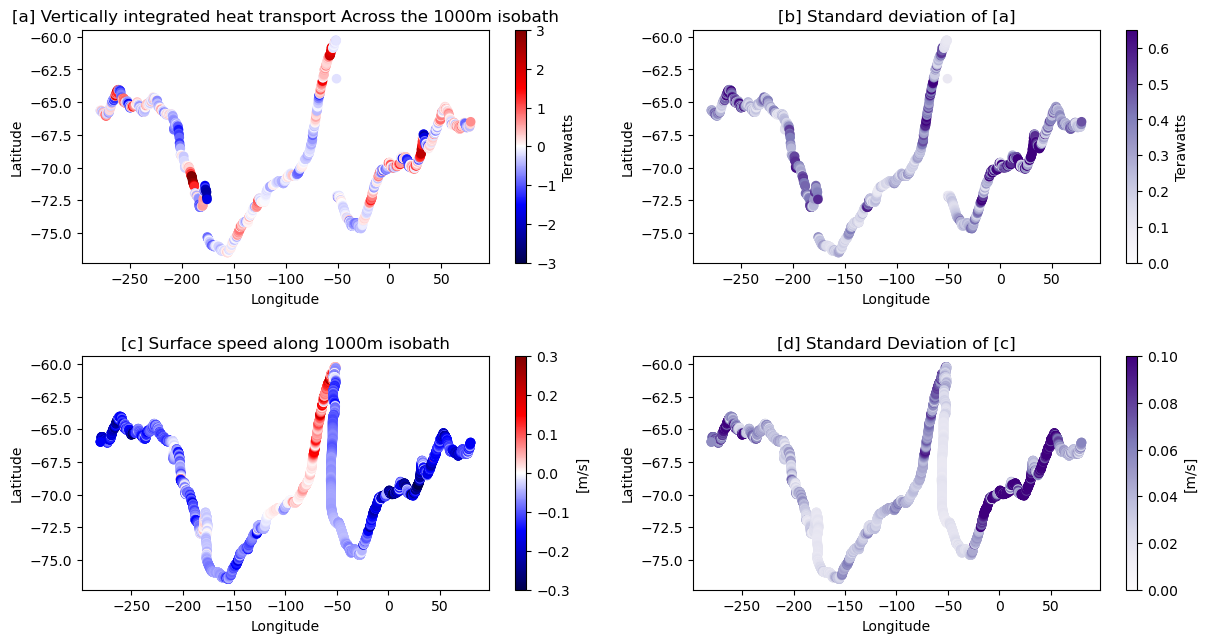

In [65]:
fig = plt.figure(figsize=(14,7))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.4)



plt.subplot(2,2,1)
#plt.scatter(Heat_transp.lon_along_contour, lat_along_contour, 
#            c=Heat_transp.heat_trans_across_contour/1e12,vmin=-3, vmax=3, s=35, cmap='seismic')
plt.scatter(Heat_transp.lon_bin_midpoints, Heat_transp.lat_bin_midpoints, 
            c=(Heat_transp.cross_slope_heat_trans*factor - Heat_transp.zonal_convergence*factor)/1e12,vmin=-3, vmax=3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[a] Vertically integrated heat transport Across the 1000m isobath')
plt.colorbar(label='Terawatts')

plt.subplot(2,2,2)
#plt.scatter(Heat_transp.lon_along_contour, lat_along_contour, 
#            c=Heat_transp_time_CONTOUR_std/1e12,vmin=0, vmax=0.8, s=35, cmap='Purples')
plt.scatter(Heat_transp.lon_bin_midpoints, Heat_transp.lat_bin_midpoints, 
            c=Cross_slope_heat_trans_std/1e12,vmin=0, vmax=0.65, s=35, cmap='Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[b] Standard deviation of [a]')
plt.colorbar(label='Terawatts')

plt.subplot(2,2,3)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v.u_along_contour.isel(st_ocean=0),vmin=-0.3, vmax=0.3, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[c] Surface speed along 1000m isobath')
plt.colorbar(label='[m/s]')

plt.subplot(2,2,4)
plt.scatter(Along_slope_v.lon_along_contour, Along_slope_v.lat_along_contour, 
            c=Along_slope_v_time_std.isel(st_ocean=0),vmin=0, vmax=0.1, s=35, cmap='Purples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('[d] Standard Deviation of [c]')
plt.colorbar(label='[m/s]')

The regions with high variability in ASC along-slope speed definitely seem to have some strong variability in ASC cross slope heat transport. The key regions seem to be:

R1 - Eastern Weddell Sea

R2 - Western Antarctic Peninsula

R3 - Eastern Prydz bay

Lets calculate a timeseries of cross slope heat transport, in a similar way as we didi for the ASC speed (two ways)

#### Integrated heat transport

Getting the ranges of the Antarctic Peninsula in the Cross Slope heat Transport

In [67]:
Heat_transp.lat_bin_midpoints

<xarray.DataArray 'lat_bin_midpoints' (lat_bin_midpoints: 1428)>
array([-65.627908, -65.585669, -65.627908, ..., -66.683892, -66.683892,
       -66.493815])
Coordinates:
  * lat_bin_midpoints  (lat_bin_midpoints) float64 -65.63 -65.59 ... -66.49

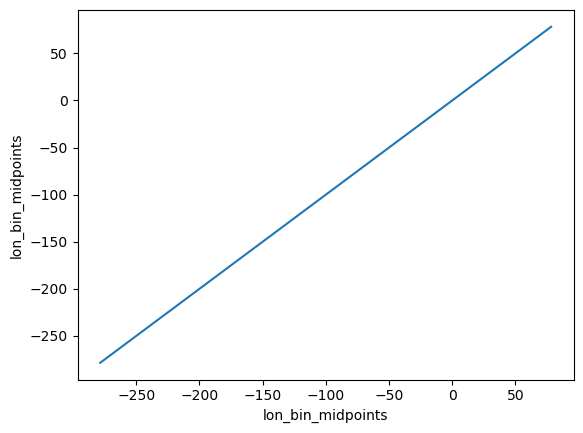

In [68]:
Heat_transp.lon_bin_midpoints.plot()

Text(0.5, 1.0, 'minlon= -100.0 and maxlon = -51.25')

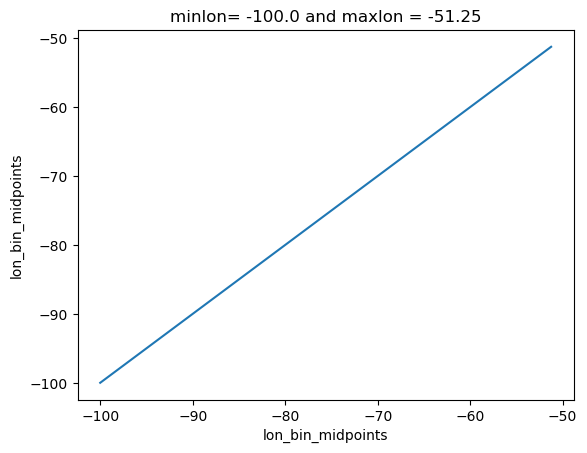

In [69]:
#We want this range (-100.00000000000345, -51.1000000000053)
minrange1=714
maxrange1=minrange1+196
minlon=np.nanmin(Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)))
maxlon=np.nanmax(Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)))
Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)).plot()
plt.title("minlon= " + str(minlon) +
         " and maxlon = " + str(maxlon))


In [70]:
Heat_transp

<xarray.Dataset>
Dimensions:                    (lon_bin_midpoints: 1428,
                                lat_bin_midpoints: 1428, lon_along_contour: 6002)
Coordinates:
  * lon_bin_midpoints          (lon_bin_midpoints) float64 -278.5 ... 78.25
  * lat_bin_midpoints          (lat_bin_midpoints) float64 -65.63 ... -66.49
  * lon_along_contour          (lon_along_contour) float64 -279.9 ... 80.0
Data variables:
    zonal_convergence          (lon_bin_midpoints) float64 dask.array<chunksize=(1428,), meta=np.ndarray>
    cross_slope_heat_trans     (lon_bin_midpoints) float64 dask.array<chunksize=(1428,), meta=np.ndarray>
    bin_width                  float64 3.0
    bin_spacing                float64 0.25
    heat_trans_across_contour  (lon_along_contour) float64 dask.array<chunksize=(6002,), meta=np.ndarray>

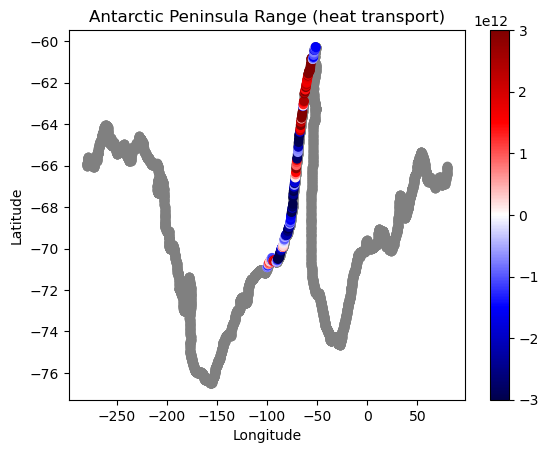

In [71]:
minrange1=714
maxrange1=minrange1+196
plt.scatter(Heat_transp.lon_along_contour,
            lat_along_contour, 
            color='grey')
plt.scatter(Heat_transp.lon_bin_midpoints.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1)),
            Heat_transp.lat_bin_midpoints.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)), 
            c=Heat_transp.cross_slope_heat_trans.isel(lon_bin_midpoints=slice(minrange1,maxrange1,1))
            ,vmin=-0.3e13, vmax=0.3e13, s=35, cmap='seismic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Antarctic Peninsula Range (heat transport)')
plt.colorbar()

In [72]:
#Importing tarea for averaging (2dvar averaged by area)
tarea_along_contour1 = tarea.sel(xt_ocean=Heat_transp.lon_bin_midpoints[10],yt_ocean=Heat_transp.lat_bin_midpoints,method='nearest')
#longitude 10 was chosen randomly ehre, as the longitude doesnt matter for the Area, only the Latitude

In [73]:
%%time

#first month is 
HT_1km = np.nansum(Heat_transp_time.cross_slope_heat_trans.isel(time=0)*tarea_along_contour1)/np.nansum(tarea_along_contour1)

for n in np.arange(1,48):
    HT_1km0=Heat_transp_time.cross_slope_heat_trans.isel(time=n)
    HT_1km1=np.nansum(HT_1km0*tarea_along_contour1)/np.nansum(tarea_along_contour1)
    HT_1km = np.append(HT_1km,HT_1km1)

CPU times: user 5.73 s, sys: 1.41 s, total: 7.14 s
Wall time: 16.4 s


Discounting the HT along the AP

In [74]:
%%time
#NOtice that here I need to sum the zonal convergence
#first month is 
HT_AP_1km = (np.nansum( (Heat_transp_time.cross_slope_heat_trans + Heat_transp_time.zonal_convergence)\
                       .isel(time=0).isel(lon_bin_midpoints=slice(minrange1,maxrange1,1))*tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)))/np.nansum(tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1))))

for n in np.arange(1,48):
    HT_AP_1km0=(Heat_transp_time.cross_slope_heat_trans + Heat_transp_time.zonal_convergence).isel(time=n).isel(lon_bin_midpoints=slice(minrange1,maxrange1,1))
    HT_AP_1km1=np.nansum(HT_AP_1km0*tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)))/np.nansum(tarea_along_contour1.isel(lat_bin_midpoints=slice(minrange1,maxrange1,1)))
    HT_AP_1km = np.append(HT_AP_1km,HT_AP_1km1)

CPU times: user 4.71 s, sys: 431 ms, total: 5.15 s
Wall time: 11.7 s


In [75]:
HTnoAP_1km=HT_1km-HT_AP_1km

How is the temporal variability of the heat transport across 1km isobath?

Text(0.5, 1.0, '01deg_jra55v13_ryf9091: yr 2095 to 2098')

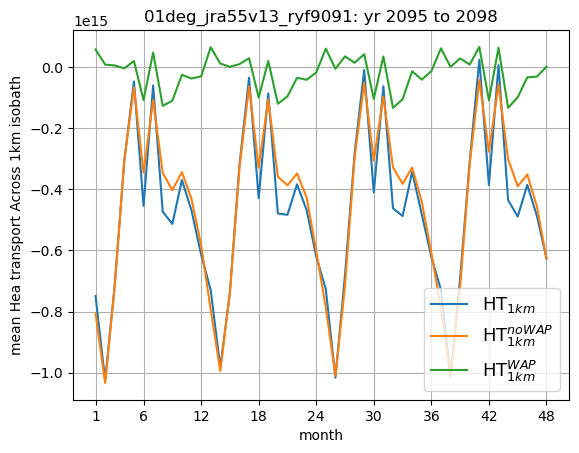

In [76]:
plt.plot(np.arange(1,49),HT_1km,label=r'HT$_{1km}$')
plt.plot(np.arange(1,49),HTnoAP_1km,label=r'HT$_{1km}^{noWAP}$')
plt.plot(np.arange(1,49),HT_AP_1km,label=r'HT$_{1km}^{WAP}$')
plt.xlabel('month')
plt.ylabel('mean Hea transport Across 1km isobath')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])
plt.legend(fontsize=13,loc='lower right')
plt.title(experiment + ': yr 2095 to 2098')

Ok, it is kind of weird that the AP makes no difference in the Integrated heat transport. mhmm

The results above are for the heat_transp_accross_contour Var, which in total should have the same value as the cross_slope_heat_trasport. However, the heat_transport_across_contour includes the zonal heat convergence in it ( which needs to be discounted). Therefore to reduct the AP, we need to use the Cross_contour_heat_transp, and reduce the zonal convergence from it

### ASC speed VS Cross slope heat Transport

Lets see the HT vs the ASC speed now

Text(0, 0.5, 'Cross slope Heat Transport [TW]')

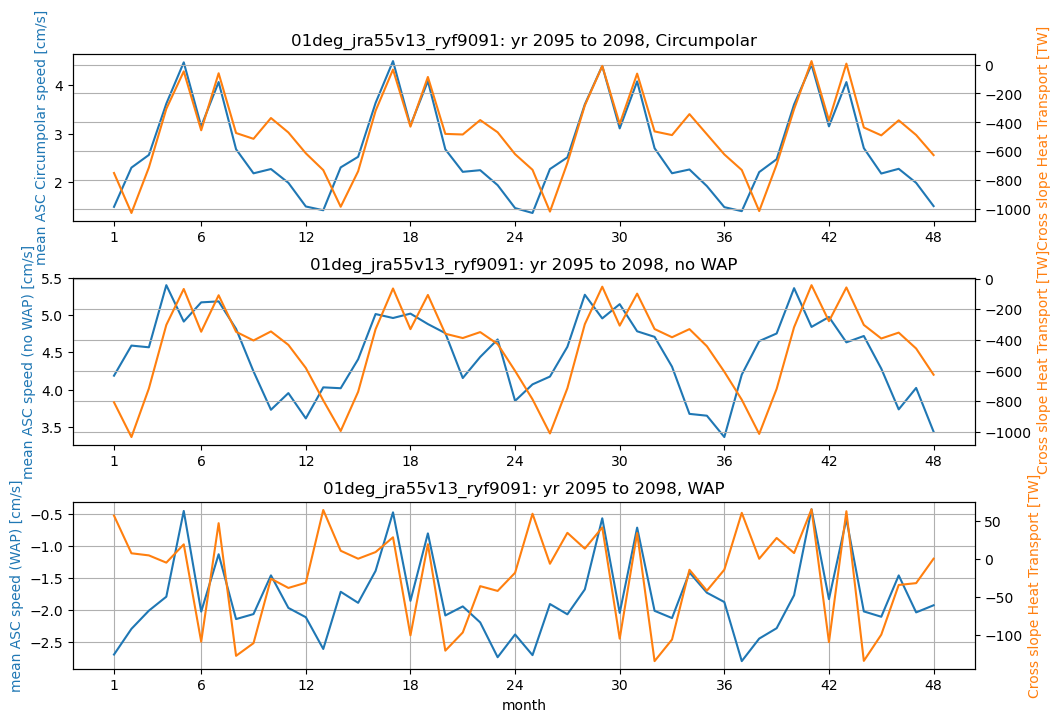

In [77]:
fig,ax = plt.subplots(3,1,figsize=(10, 7))
fig.tight_layout(pad=2.0)

#subplot1
ax[0].set_title(experiment + ': yr 2095 to 2098, Circumpolar')
ax[0].plot(np.arange(1,49),-ASC_u*100,label=r'U$_{1km}$',color='tab:blue')
plt.xlabel('month')
ax[0].set_ylabel('mean ASC Circumpolar speed [cm/s]',color='tab:blue')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])




ax2=ax[0].twinx()
plt.plot(np.arange(1,49),HT_1km/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax2.set_ylabel('Cross slope Heat Transport [TW]',color='tab:orange')


#subplot2
ax[1].set_title(experiment + ': yr 2095 to 2098, no WAP')
ax[1].plot(np.arange(1,49),-ASC_unoAP*100,label=r'U$_{1km}$',color='tab:blue')
plt.xlabel('month')
ax[1].set_ylabel('mean ASC speed (no WAP) [cm/s]',color='tab:blue')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])



ax3=ax[1].twinx()
plt.plot(np.arange(1,49),HTnoAP_1km/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax3.set_ylabel('Cross slope Heat Transport [TW]',color='tab:orange')



#subplot3
ax[2].set_title(experiment + ': yr 2095 to 2098, WAP')
ax[2].plot(np.arange(1,49),-ASC_uAP*100,label=r'U$_{1km}$',color='tab:blue')
plt.xlabel('month')
ax[2].set_ylabel('mean ASC speed (WAP) [cm/s]',color='tab:blue')
plt.grid()
plt.xticks([1,6,12,18,24,30,36,42,48])



ax4=ax[2].twinx()
plt.plot(np.arange(1,49),HT_AP_1km/1e12,label=r'HT$_{1km}$',color='tab:orange')
ax4.set_ylabel('Cross slope Heat Transport [TW]',color='tab:orange')

On a spatial mean, it definetly seem that the stronger the ASC, the weaker is the cross-slope heat transport. On a total spatial average

What about some simple dispersion plot

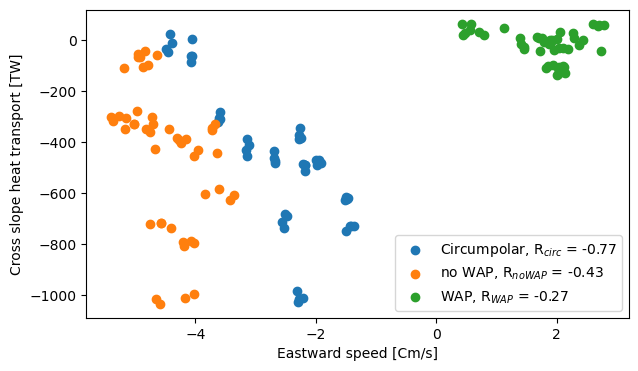

In [84]:
fig,ax = plt.subplots(figsize=(7, 4))
# the correlation:
coeffpC = np.corrcoef(ASC_u,HT_1km/1e12)
coeffpnoAP = np.corrcoef(ASC_unoAP,HTnoAP_1km/1e12)
coeffpAP = np.corrcoef(ASC_uAP,HT_AP_1km/1e12)
#the plot
plt.scatter(ASC_u*100,HT_1km/1e12,label=r"Circumpolar, R$_{circ}$ = " + str(np.real(np.int(coeffpC[0,1]*100))/100))
plt.scatter(ASC_unoAP*100,HTnoAP_1km/1e12,label=r"no WAP, R$_{noWAP}$ = " + str(np.real(np.int(coeffpnoAP[0,1]*100))/100) )
plt.scatter(ASC_uAP*100,HT_AP_1km/1e12,label=r"WAP, R$_{WAP}$ = " + str(np.real(np.int(coeffpAP[0,1]*100))/100))
plt.xlabel('Eastward speed [Cm/s]')
plt.ylabel('Cross slope heat transport [TW]')
plt.legend(loc='lower right')

**CIRCUMPOLAR CASE:** It seems that this inverse relationship is more robust on High speed regimes ( ASC sspeeds >0.03 m/s). So strongest in the winter, and weakest in the summer.

**NO WAP CASE:** Correlation here seem to be smaller ( and in fact series seem to be less *in sync* when we see the previous plot). Temporal variability seem to still be somewhat similar tho)

**ONLY WAP CASE:** Correlation is positive, but smaller than the case of total transport

#### An important caveat

For some reason, even using the same code, the heat transports that I find are not equal to the ones founs by Adele's 2020 paper. We have to chat to figure it out why - Ask Adele if she would have any clue.... (Maybe is just not suppose to be correct)

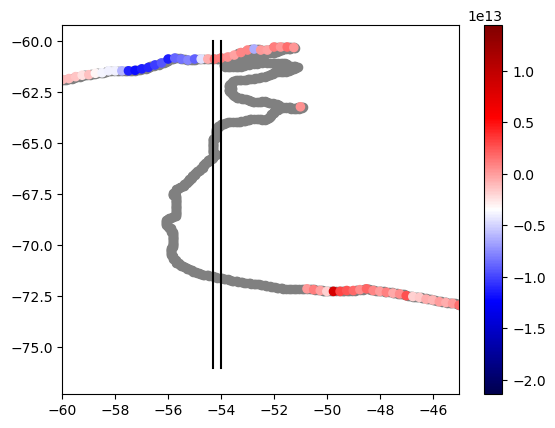

In [230]:
#How would a 0.1 digree binning work in the AP??
plt.scatter(Heat_transp.lon_along_contour,lat_along_contour,s=35, color='gray')
plt.scatter(Heat_transp.lon_bin_midpoints,Heat_transp.lat_bin_midpoints,c=Heat_transp.zonal_convergence,s=35, cmap='seismic')
plt.plot([-54.3,-54.3],[-76,-60],color='k')
plt.plot([-54,-54],[-76,-60],color='k')
plt.xlim(-60,-45)
plt.colorbar()

(-60.0, -40.0)

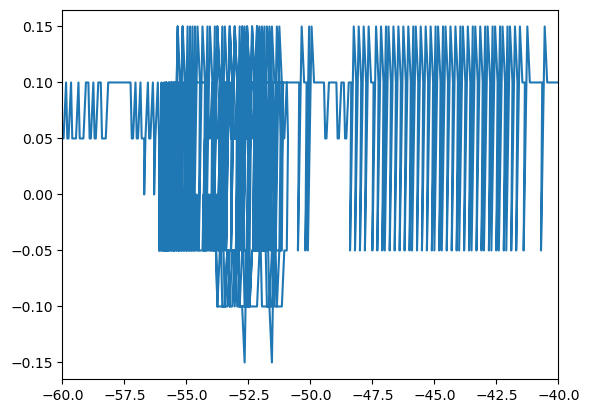

In [217]:
plt.plot(Heat_transp.lon_along_contour[1:],np.diff(Heat_transp.lon_along_contour))
plt.xlim(-60,-40)

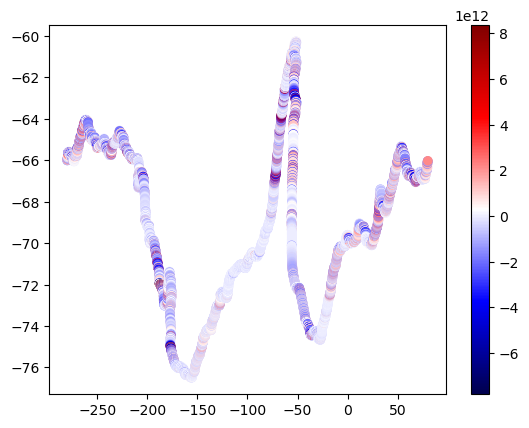

In [35]:
#Heat_transp.heat_trans_across_contour
plt.scatter(Heat_transp.lon_along_contour,lat_along_contour,c=Heat_transp.heat_trans_across_contour,s=35, cmap='seismic')
#plt.scatter(Heat_transp.lon_bin_midpoints,Heat_transp.lat_bin_midpoints,c=Heat_transp.zonal_convergence,s=35, cmap='seismic')
plt.colorbar()

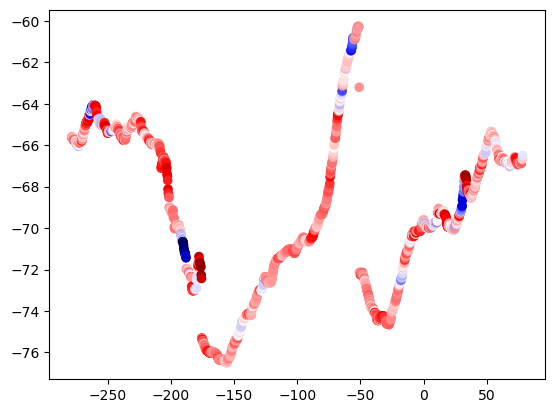

In [36]:
plt.scatter(Heat_transp.lon_bin_midpoints,Heat_transp.lat_bin_midpoints,c=Heat_transp.zonal_convergence,s=35, cmap='seismic')

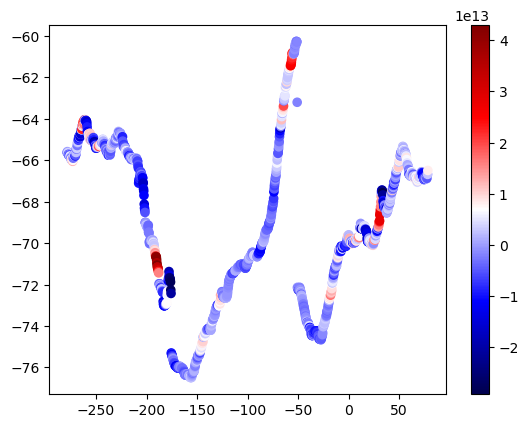

In [37]:
plt.scatter(Heat_transp.lon_bin_midpoints,Heat_transp.lat_bin_midpoints,c=(Heat_transp.cross_slope_heat_trans - Heat_transp.zonal_convergence),s=35, cmap='seismic')
plt.colorbar()



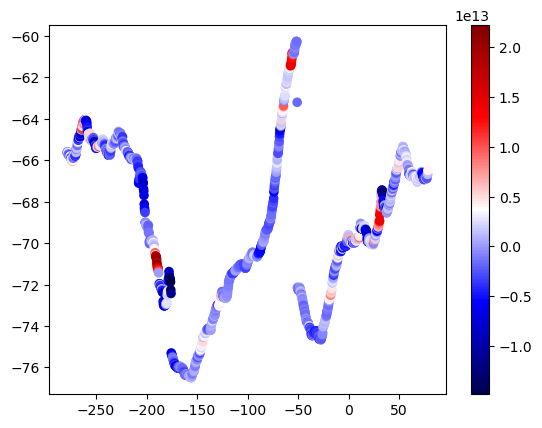

In [38]:
plt.scatter(Heat_transp.lon_bin_midpoints,Heat_transp.lat_bin_midpoints,c=(Heat_transp.cross_slope_heat_trans),s=35, cmap='seismic')
plt.colorbar()



In [39]:
Heat_transp.cross_slope_heat_trans

<xarray.DataArray 'cross_slope_heat_trans' (lon_bin_midpoints: 1428)>
dask.array<mean_agg-aggregate, shape=(1428,), dtype=float64, chunksize=(1428,), chunktype=numpy.ndarray>
Coordinates:
  * lon_bin_midpoints  (lon_bin_midpoints) float64 -278.5 -278.2 ... 78.0 78.25

In [40]:
factor = np.nansum(Heat_transp.heat_trans_across_contour)/np.nansum(Heat_transp.cross_slope_heat_trans)
factor

0.08130129165602648

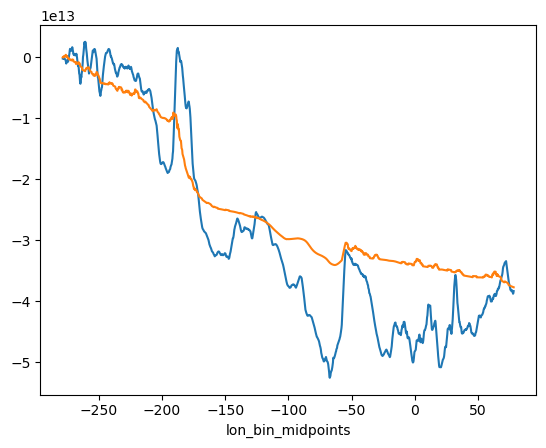

In [41]:
(Heat_transp.cross_slope_heat_trans*factor).cumsum(dim='lon_bin_midpoints').plot()
(Heat_transp.cross_slope_heat_trans*factor + Heat_transp.zonal_convergence*factor).cumsum(dim='lon_bin_midpoints').plot()

As you can see, removing the zonal convergence greatly smoothes out a lot the heat transport. So we need to remove the heat convergence.  The way that Adele did was to bin the contour zonally. However, this erases all the points along the Antarctic Peninsula, which is not convenient for me. I will try to bin it according to distance along the contour, so then we cover convergence withing the contour (zonal + meridional), and not only meridional.

#### A possible solution

As you can see above, binning is very important for the final heat transport. Ill Bin the heat transport again, but instead of doing by lon I will do by the distance from the initial point. This way the binning can be done independend of the contour being zonal or meridional

In [42]:
#calculating distance along contour
lon_along_contour=Heat_transp.lon_along_contour
import geopy.distance

#first case
coords_1 = (lat_along_contour[0], lon_along_contour[0])
distance_along_contour = geopy.distance.geodesic(coords_1, coords_1).km




for n in np.arange(0,6001):
    coords_1 = (lat_along_contour[n], lon_along_contour[n])
    coords_2 = (lat_along_contour[n+1], lon_along_contour[n+1])
    
    dist = geopy.distance.geodesic(coords_1, coords_2).km
    
    distance_along_contour = np.append(distance_along_contour,dist)
distance_along_contour=np.cumsum(distance_along_contour)

I will bib the data by to the distance along contour instead of by the lon. lets try that

In [197]:
bin_width = 300 # km, bin spacing and widh were chosen to reflect a similar coarsening factor as the one done by long/lat binning
bin_spacing = 10*2.5 #km
dist_west = 0
dist_east = np.max(distance_along_contour)

full_dist_coord = np.arange(dist_west,dist_east+bin_spacing,bin_spacing)
dist_bin_midpoints = np.arange(dist_west+bin_width/2,dist_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_dist_coord)

heat_transp_tobin=np.array(Heat_transp.heat_trans_across_contour)
heat_transp_binned=0
lon_bin_midpoints2=0
lat_bin_midpoints2=0

for n in np.arange(0,np.size(full_dist_coord)):
    dist_range=[full_dist_coord[n]-(bin_width/2),full_dist_coord[n]+(bin_width/2)]
    points_sel=np.where((distance_along_contour<=dist_range[1]) & (distance_along_contour>=dist_range[0]))
    value_sel = np.sum(heat_transp_tobin[points_sel])
    lon2 = np.nanmean(Heat_transp.lon_along_contour[points_sel])
    lat2 = np.nanmean(lat_along_contour[points_sel])
    lon_bin_midpoints2=np.append(lon_bin_midpoints2,lon2)
    lat_bin_midpoints2=np.append(lat_bin_midpoints2,lat2)
    heat_transp_binned=np.append(heat_transp_binned,value_sel)
    
heat_transp_binned=heat_transp_binned[1:]
lon_bin_midpoints2=lon_bin_midpoints2[1:]
    
    
    


In [195]:
#calculating the correction factor for the newly binned values
factor2 = np.nansum(Heat_transp.heat_trans_across_contour)/np.nansum(heat_transp_binned)
factor2

#correcting the values
heat_transp_binned=heat_transp_binned*factor2

0.08297154456209321

Now we need to somehow calculate the contour divergence, to discount from the binned transport. Check how Adele did it. She calculated the difference of the zonal heat transport in the edges of each cell

In [206]:
n_bins = np.size(lon_bin_midpoints)
zonal_heat_trans_west = np.zeros(n_bins)

# for lon_bin in range(n_bins):


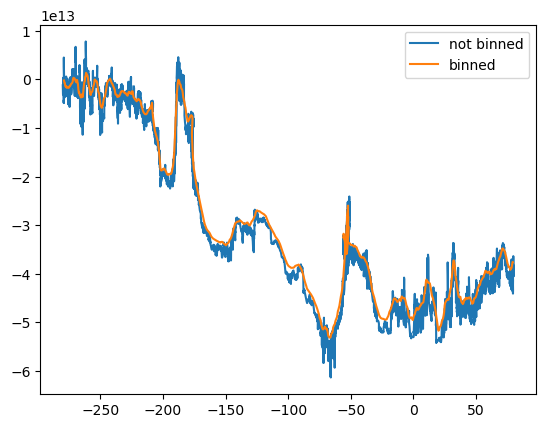

In [202]:
#plotting
plt.plot(Heat_transp.lon_along_contour,np.cumsum(Heat_transp.heat_trans_across_contour),label='not binned')
plt.plot(lon_bin_midpoints2,np.cumsum(heat_transp_binned*factor),label='binned')
plt.legend()

In [ ]:
# #
# plt.plot(np.cumsum(Heat_transp.heat_trans_across_contour),label='Heat Transport')
# plt.plot(np.cumsum(heat_trans_movav),label='MOVAV')
# plt.grid()
# plt.legend()
# #SO I guess moving average doesnt work

Next on: Lets try to bin the heat_trans_across_contour throughout the points. 